In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt
from src.create_lattice import build_lattice, clean_deribit, read_parquet
from src.noarb_lattice import build_noarb_constraints, projection_fast_cvxpy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd


In [ ]:
df = read_parquet("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")

df = clean_deribit(df = df)

# Splitting the test and train data 
# Doing this now to avoid data leakage when interpolating & projecting
df = df.sort_values(by='timestamp')
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Build train and test lattices
train_C_interp, train_nodes, train_tau_grid, train_m_grid = build_lattice(train_df)
test_C_interp, test_nodes, test_tau_grid, test_m_grid = build_lattice(test_df)

# Create no-arbitrage withstanding projections
train_projection = projection(train_C_interp, train_nodes, train_tau_grid, train_m_grid)
test_projection = projection(test_C_interp, train_nodes, train_tau_grid, train_m_grid)


In [ ]:
# 1) Load, clean, sort, split
df       = read_parquet("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")
df       = clean_deribit(df)
df       = df.sort_values("timestamp")
i_split  = int(len(df)*0.8)
train_df = df.iloc[:i_split]
test_df  = df.iloc[i_split:]

# 2) BUILD LATTICE *ON TRAIN ONLY*
train_C_sparse, train_nodes, train_tau_grid, train_m_grid = build_lattice(train_df)

# 3) FIT NN ASSIGNMENT MODEL ON TRAIN NODES
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(train_nodes)

# 4) FOR EACH SET: interpolate & project (no-arb), but using TRAIN’s lattice
def make_projection(df_subset):
    C_sparse, _, _, _ = build_lattice(df_subset,
                                      nodes=train_nodes,       # reuse
                                      tau_grid=train_tau_grid,
                                      m_grid=train_m_grid)
    # time‐interpolate (causal if you like)
    C_interp = C_sparse.interpolate(...).ffill().bfill()
    # project to no-arb
    return projection(C_interp, train_nodes, train_tau_grid, train_m_grid)

train_proj = make_projection(train_df)
test_proj  = make_projection(test_df)

In [ ]:
# Create the DT for test and train 
# We now extract the timesteps between observed option snapshot
train_timestamps = train_projection.index.to_series()
test_timestamps = test_projection.index.to_series()

# Compute raw delta t in seconds (or fractions of a second) between each row
train_dt_secs = train_timestamps.diff().dt.total_seconds().to_numpy()
test_dt_secs = test_timestamps.diff().dt.total_seconds().to_numpy()


# the first value for dt is na so we just assume that its the same as the next value
train_dt_secs[0] = train_dt_secs[1]
test_dt_secs[0] = test_dt_secs[1]

train_dt_secs = train_dt_secs.astype(np.float32)
test_dt_secs = test_dt_secs.astype(np.float32)

# Convert to tensor
train_dt_tensor = torch.from_numpy(train_dt_secs).float()
test_dt_tensor = torch.from_numpy(test_dt_secs).float()

In [ ]:
# Test and train tensors
train_tensor_af = torch.from_numpy(train_projection.values).float()
test_tensor_af = torch.from_numpy(test_projection.values).float()

# Load dt tensor

surf_train = train_tensor_af
surf_test = test_tensor_af

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)
n_train = surf_train.size(0)
n_test  = surf_test.size(0)
n_train, dim = surf_train.shape
n_test, _ = surf_test.shape

# align dt
dt_train = train_dt_tensor.to(device)
dt_test = test_dt_tensor.to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(dim).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 500
batch_size = 60


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(n_train - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (n_train - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")


# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [2]:
def build_lattice_grid(df, n_tau=5, n_m=5, top_K=50):
    """
    From raw df (train only), learn:
      - tau_grid, m_grid
      - full nodes array
      - fitted NearestNeighbors on those nodes
    """
    # 1) learn tau_grid via KMeans
    unique_taus = np.sort(df['tau'].unique()).reshape(-1,1)
    tau_kmeans = KMeans(n_clusters=n_tau, random_state=0).fit(unique_taus)
    tau_grid   = tau_kmeans.cluster_centers_.flatten()
    df['tau_cluster'] = tau_kmeans.predict(df[['tau']])
    
    # 2) build m_grid for each tau from percentiles
    m_grid = {}
    for label, tau in enumerate(tau_grid):
        subset = df[df['tau_cluster']==label]
        lo, hi  = np.percentile(subset['m'], [1,99])
        m_grid[tau] = np.linspace(lo, hi, n_m)
    
    # 3) build nodes & NN
    nodes = np.vstack([ [tau, m] 
                        for tau in tau_grid 
                        for m in m_grid[tau] ])
    nn    = NearestNeighbors(n_neighbors=1).fit(nodes)
    
    return nn, nodes, tau_grid, m_grid

def apply_lattice(df, nn, nodes, tau_grid, m_grid, 
                  top_K=50, fill_method="linear"):
    """
    Given any df plus a prebuilt (nn, nodes, tau_grid, m_grid),
    snap-to-nodes, pick top_K by liquidity, pivot → C_sparse,
    drop never-observed, rebuild sub-nodes & sub-m_grid,
    then interpolate & fill → C_interp.
    """
    # snap each (τ,m) via nn
    pts = df[['tau','m']].values
    idx = nn.kneighbors(pts, return_distance=False)[:,0]
    df = df.assign(node_idx=idx,
                   lattice_tau=nodes[idx,0],
                   lattice_m=nodes[idx,1])
    
    # pick most liquid per timestamp/node
    best = (
      df.sort_values('stats_volume_usd', ascending=False)
        .drop_duplicates(['timestamp','node_idx'])
        .assign(timestamp=pd.to_datetime(df['timestamp']))
    )
    
    # pivot to sparse C
    top_nodes = df['node_idx'].value_counts().nlargest(top_K).index
    sub       = best[best['node_idx'].isin(top_nodes)]
    C_sparse  = sub.pivot_table('mid_price','timestamp','node_idx')
    
    # drop never observed & rebuild sub-nodes, sub grids
    never_obs = C_sparse.columns[C_sparse.isna().all()]
    C_sparse  = C_sparse.drop(columns=never_obs)
    present   = C_sparse.columns.astype(int).to_numpy()
    nodes_sub = nodes[present]
    tau_sub   = np.unique(nodes_sub[:,0])
    m_sub     = {τ: sorted(nodes_sub[nodes_sub[:,0]==τ,1]) for τ in tau_sub}
    
    # interpolate & fill
    C_interp = (C_sparse
                  .interpolate(method=fill_method,axis=0)
                  .ffill().bfill())
    
    return C_interp, nodes_sub, tau_sub, m_sub


In [3]:
file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]

train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()



# # Learn lattice grid only on train
# # 1) Learn the lattice grid once on train:
# nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# # 2) Independently interpolate & project each split — but *reuse* the train’s lattice:
# train_C_interp, *_ = apply_lattice(train_df, nn, full_nodes, full_tau_grid, full_m_grid)
# test_C_interp,  *_ = apply_lattice(test_df,  nn, full_nodes, full_tau_grid, full_m_grid)

# n_full = full_nodes.shape[0]
# train_C_interp = (
#     train_C_interp
#       .reindex(columns=range(n_full))       # introduce missing node-columns as NaN
#       .interpolate(method='linear', axis=0) # re-interpolate them
#       .ffill().bfill()                      # then fill any end-gaps
# )

# test_C_interp = (
#     test_C_interp
#       .reindex(columns=range(n_full))
#       .interpolate(method='linear', axis=0)
#       .ffill().bfill()
# )

# 1) Learn the lattice grid once on train:
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# 2) Apply lattice to get each C_interp **and** its observed node‐indices
train_Ci, train_nodes_sub, train_tau_sub, train_m_sub = apply_lattice(
    train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
test_Ci,  test_nodes_sub,  test_tau_sub,  test_m_sub  = apply_lattice(
    test_df,  nn, full_nodes, full_tau_grid, full_m_grid
)

# extract the integer node‐indices from the DataFrame’s columns
train_idx = sorted(train_Ci.columns.astype(int))
test_idx  = sorted(test_Ci.columns.astype(int))

# 3) Compute the intersection → only keep nodes seen in BOTH
common_idx = sorted(set(train_idx) & set(test_idx))

# 4) Restrict & clean up each C_interp to exactly common_idx
def restrict_and_fill(Ci, idxs):
    Ci2 = Ci.reindex(columns=idxs) \
            .interpolate(method='linear', axis=0) \
            .ffill().bfill()
    return Ci2

train_Ci = restrict_and_fill(train_Ci, common_idx)
test_Ci  = restrict_and_fill(test_Ci,  common_idx)

# 5) Build no‐arb constraints on the common node‐set
common_nodes    = full_nodes[common_idx]  # shape [N_common,2]
common_tau_grid = np.unique(common_nodes[:,0])
common_m_grid   = {τ: sorted(common_nodes[common_nodes[:,0]==τ,1])
                   for τ in common_tau_grid}

A, b = build_noarb_constraints(common_nodes, common_tau_grid, common_m_grid)


# 3) Project onto no‐arb polytope with same nodes/taus/m's
# new, fast warm-start calls:
train_proj = projection_fast_cvxpy(
    train_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)
test_proj = projection_fast_cvxpy(
    test_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)

# 4) Now force test to have the same columns as train:
test_proj = test_proj.reindex(columns=train_proj.columns)

# 5) Convert to tensors – they’ll both be [T, N] with identical N
train_tensor_af = torch.from_numpy(train_proj.values).float()
test_tensor_af  = torch.from_numpy(test_proj.values).float()



/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [4]:
torch.save(train_tensor_af, "train_tensor_af.pt")
torch.save(test_tensor_af, "test_tensor_af.pt")

In [6]:
# Savin the dt tensors for test and train
# We now extract the timesteps between observed option snapshot
timestamps_train = train_Ci.index.to_series()
timestamps_test = test_Ci.index.to_series()

# Compute raw delta t in seconds (or fractions of a second) between each row
dt_secs_train = timestamps_train.diff().dt.total_seconds().to_numpy()
dt_secs_test = timestamps_test.diff().dt.total_seconds().to_numpy()

# the first value for dt is na so we just assume that its the same as the next value
dt_secs_train[0] = dt_secs_train[1]
dt_secs_test[0] = dt_secs_test[1]


dt_secs_train = dt_secs_train.astype(np.float32)
dt_secs_test = dt_secs_test.astype(np.float32)

# Convert to tensor
dt_tensor_train = torch.from_numpy(dt_secs_train).float()
dt_tensor_test = torch.from_numpy(dt_secs_test).float()

# Save
torch.save(dt_tensor_train, "dt_train.pt")
torch.save(dt_tensor_test, "dt_test.pt")

56400
Epoch 1/500  Train NLL: -2.6190e+00  Test NLL: -3.6009e+00
56400
Epoch 2/500  Train NLL: -3.8761e+00  Test NLL: -3.7824e+00
56400
Epoch 3/500  Train NLL: -3.9470e+00  Test NLL: -3.8273e+00
56400
Epoch 4/500  Train NLL: -3.9692e+00  Test NLL: -3.8771e+00
56400
Epoch 5/500  Train NLL: -3.9829e+00  Test NLL: -3.8358e+00
56400
Epoch 6/500  Train NLL: -4.0053e+00  Test NLL: -3.9301e+00
56400
Epoch 7/500  Train NLL: -4.0020e+00  Test NLL: -3.8909e+00
56400
Epoch 8/500  Train NLL: -4.0160e+00  Test NLL: -3.8536e+00
56400
Epoch 9/500  Train NLL: -4.0054e+00  Test NLL: -3.9319e+00
56400
Epoch 10/500  Train NLL: -4.0109e+00  Test NLL: -3.9240e+00
56400
Epoch 11/500  Train NLL: -4.0340e+00  Test NLL: -3.8648e+00
56400
Epoch 12/500  Train NLL: -4.0214e+00  Test NLL: -3.9071e+00
56400
Epoch 13/500  Train NLL: -4.0186e+00  Test NLL: -3.8381e+00
56400
Epoch 14/500  Train NLL: -4.0222e+00  Test NLL: -3.9204e+00
56400
Epoch 15/500  Train NLL: -4.0301e+00  Test NLL: -3.8480e+00
56400
Epoch 16/500 

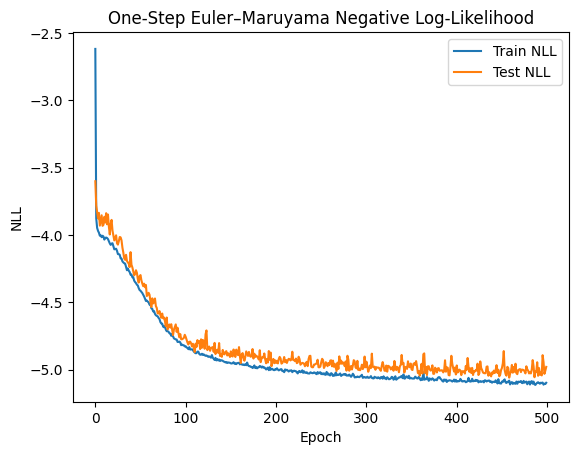

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt
# Test and train tensors
train_tensor_af = torch.load("train_tensor_af.pt")
test_tensor_af = torch.load("test_tensor_af.pt")

# Load dt tensor
dt_test = torch.load("dt_test.pt")
dt_train = torch.load("dt_train.pt")


surf_train = train_tensor_af
surf_test = test_tensor_af

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)
n_train = surf_train.size(0)
n_test  = surf_test.size(0)
n_train, dim = surf_train.shape
n_test, _ = surf_test.shape

# align dt
dt_train = dt_train.to(device)
dt_test = dt_test.to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(dim).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 500
batch_size = 60


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(n_train - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()
        if torch.isnan(loss):
            print("NaN in NLL: ",
                  "var min/max:", var.min().item(), var.max().item(),
                  "drift min/max:", drift.min().item(), drift.max().item(),
                  "diff min/max:", diff.min().item(), diff.max().item(),
                  "dy min/max:", dy.min().item(), dy.max().item(),
                  "dt min/max:", dt.min().item(), dt.max().item())
            raise RuntimeError("NaN in loss")

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (n_train - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        print(y0_test.numel())
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")


# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [42]:
# Load dt tensor
dt_test = torch.load("dt_test.pt")
dt_train = torch.load("dt_train.pt")

In [43]:
print("dt_train  min/max:", dt_secs_train.min(), dt_secs_train.max())
print("dt_test   min/max:",  dt_secs_test.min(),  dt_secs_test.max())


dt_train  min/max: 0.001 32.224
dt_test   min/max: 0.001 22.054


In [1]:
import torch
import torch.nn as neuralnet
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt
from src.create_lattice import build_lattice_grid, clean_deribit, read_parquet, apply_lattice
from src.noarb_lattice import build_noarb_constraints, projection_fast_cvxpy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from src.decomp_lattice import compute_surface_curl


In [2]:
file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]

train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()

# 1) Learn the lattice grid once on train:
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# 2) Apply lattice to get each C_interp **and** its observed node‐indices
train_Ci, train_nodes_sub, train_tau_sub, train_m_sub = apply_lattice(
    train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
test_Ci,  test_nodes_sub,  test_tau_sub,  test_m_sub  = apply_lattice(
    test_df,  nn, full_nodes, full_tau_grid, full_m_grid
)

# extract the integer node‐indices from the DataFrame’s columns
train_idx = sorted(train_Ci.columns.astype(int))
test_idx  = sorted(test_Ci.columns.astype(int))

# 3) Compute the intersection → only keep nodes seen in BOTH
common_idx = sorted(set(train_idx) & set(test_idx))

# 4) Restrict & clean up each C_interp to exactly common_idx
def restrict_and_fill(Ci, idxs):
    Ci2 = Ci.reindex(columns=idxs) \
            .interpolate(method='linear', axis=0) \
            .ffill().bfill()
    return Ci2

train_Ci = restrict_and_fill(train_Ci, common_idx)
test_Ci  = restrict_and_fill(test_Ci,  common_idx)

# 5) Build no‐arb constraints on the common node‐set
common_nodes    = full_nodes[common_idx]  # shape [N_common,2]
common_tau_grid = np.unique(common_nodes[:,0])
common_m_grid   = {τ: sorted(common_nodes[common_nodes[:,0]==τ,1])
                   for τ in common_tau_grid}

A, b = build_noarb_constraints(common_nodes, common_tau_grid, common_m_grid)


# 3) Project onto no‐arb polytope with same nodes/taus/m's
# new, fast warm-start calls:
train_proj = projection_fast_cvxpy(
    train_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)
test_proj = projection_fast_cvxpy(
    test_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)

# 4) Now force test to have the same columns as train:
test_proj = test_proj.reindex(columns=train_proj.columns)

# 5) Convert to tensors – they’ll both be [T, N] with identical N
train_tensor_af = torch.from_numpy(train_proj.values).float()
test_tensor_af  = torch.from_numpy(test_proj.values).float()


/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Compute Surface Curl Factors for Dynamic Arbitrage

In [5]:
import numpy as np

def compute_surface_curl(C_interp, nodes, tau_grid, m_grid, gamma_sq=None, tol=1e-8):
    """
    Compute Z[t,j] = -∂_τ C - ½ γ² ∂_m C + ½ γ² ∂²_m C on your lattice.

    C_interp : pd.DataFrame, shape (T, N)
    nodes     : np.ndarray (N,2) of [tau_j, m_j]
    tau_grid  : array-like sorted unique taus
    m_grid    : dict { tau -> sorted list of m’s }
    gamma_sq  : optional array of length T; defaults to 1
    tol       : tolerance for matching floats

    Returns Z : np.ndarray, shape (T, N)
    """
    C = C_interp.values      # (T, N)
    T, N = C.shape
    if gamma_sq is None:
        gamma_sq = np.ones(T)

    tau_arr = np.asarray(tau_grid)

    # Precompute neighbor indices for each node j
    nbr = [{} for _ in range(N)]
    for j in range(N):
        τ_j, m_j = nodes[j]
        # find the index in tau_arr closest to τ_j
        iτ = int(np.argmin(np.abs(tau_arr - τ_j)))

        # τ-neighbors for central difference
        if 0 < iτ < len(tau_arr) - 1:
            τ_dn, τ_up = tau_arr[iτ - 1], tau_arr[iτ + 1]
            # find node at (τ_dn, m_j)
            candidates = np.where(
                (np.isclose(nodes[:,0], τ_dn, atol=tol)) &
                (np.isclose(nodes[:,1], m_j,   atol=tol))
            )[0]
            k_dn = candidates[0] if candidates.size else None
            # likewise for τ_up
            candidates = np.where(
                (np.isclose(nodes[:,0], τ_up, atol=tol)) &
                (np.isclose(nodes[:,1], m_j,   atol=tol))
            )[0]
            k_up = candidates[0] if candidates.size else None
        else:
            k_dn = k_up = None

        # m-neighbors at the same τ_j
        ms = m_grid[τ_j]
        # find index in ms closest to m_j
        im = int(np.argmin([abs(m - m_j) for m in ms]))
        if 0 < im < len(ms) - 1:
            m_l, m_r = ms[im - 1], ms[im + 1]
            # find node indices for those
            left = np.where(
                (np.isclose(nodes[:,0], τ_j, atol=tol)) &
                (np.isclose(nodes[:,1], m_l,  atol=tol))
            )[0]
            right = np.where(
                (np.isclose(nodes[:,0], τ_j, atol=tol)) &
                (np.isclose(nodes[:,1], m_r,  atol=tol))
            )[0]
            k_left = left[0] if left.size else None
            k_right= right[0] if right.size else None
        else:
            k_left = k_right = None

        nbr[j] = dict(tau_dn=k_dn, tau_up=k_up, m_left=k_left, m_right=k_right)

    # allocate output
    Z = np.zeros((T, N), dtype=float)

    # loop over time and nodes
    for t in range(T):
        C_t = C[t]
        g2  = gamma_sq[t]

        for j in range(N):
            nb = nbr[j]
            val = 0.0

            # ∂_τ
            if nb['tau_dn'] is not None and nb['tau_up'] is not None:
                dτ = nodes[nb['tau_up'],0] - nodes[nb['tau_dn'],0]
                val -= (C_t[nb['tau_up']] - C_t[nb['tau_dn']]) / dτ

            # ∂_m and ∂²_m
            if nb['m_left'] is not None and nb['m_right'] is not None:
                dm = nodes[nb['m_right'],1] - nodes[nb['m_left'],1]
                C_l, C_c, C_r = C_t[nb['m_left']], C_t[j], C_t[nb['m_right']]
                val += -0.5 * g2 * ( (C_r - C_l) / dm )
                val +=  0.5 * g2 * ( (C_r - 2*C_c + C_l) / (dm**2) )

            Z[t,j] = val

    return Z


Z=compute_surface_curl(train_proj,common_nodes,common_tau_grid,common_m_grid)

In [8]:
file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]

train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()

# 1) Learn the lattice grid once on train:
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# 2) Apply lattice to get each C_interp **and** its observed node‐indices
train_Ci, train_nodes_sub, train_tau_sub, train_m_sub = apply_lattice(
    train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
test_Ci,  test_nodes_sub,  test_tau_sub,  test_m_sub  = apply_lattice(
    test_df,  nn, full_nodes, full_tau_grid, full_m_grid
)

# extract the integer node‐indices from the DataFrame’s columns
train_idx = sorted(train_Ci.columns.astype(int))
test_idx  = sorted(test_Ci.columns.astype(int))

# 3) Compute the intersection → only keep nodes seen in BOTH
common_idx = sorted(set(train_idx) & set(test_idx))

# 4) Restrict & clean up each C_interp to exactly common_idx
def restrict_and_fill(Ci, idxs):
    Ci2 = Ci.reindex(columns=idxs) \
            .interpolate(method='linear', axis=0) \
            .ffill().bfill()
    return Ci2

train_Ci = restrict_and_fill(train_Ci, common_idx)
test_Ci  = restrict_and_fill(test_Ci,  common_idx)

# 5) Build no‐arb constraints on the common node‐set
common_nodes    = full_nodes[common_idx]  # shape [N_common,2]
common_tau_grid = np.unique(common_nodes[:,0])
common_m_grid   = {τ: sorted(common_nodes[common_nodes[:,0]==τ,1])
                   for τ in common_tau_grid}

A, b = build_noarb_constraints(common_nodes, common_tau_grid, common_m_grid)


# 3) Project onto no‐arb polytope with same nodes/taus/m's
# new, fast warm-start calls:
train_proj = projection_fast_cvxpy(
    train_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)
test_proj = projection_fast_cvxpy(
    test_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)

/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Extracting Dynamic Arb Factors

In [10]:
from sklearn.decomposition import PCA

d_da = 2
pca_da = PCA(n_components=d_da)
eps_da = pca_da.fit_transform(Z)
G_da = pca_da.components_.T  # shape (N, d_da)

C = train_proj.values
G0 = C.mean(axis = 0)
C_res = C - eps_da.dot(G_da.T)

In [11]:
pca_st = PCA(n_components=0.95, whiten=True)
eps_st = pca_st.fit_transform(C_res)
G_st = pca_st.components_.T  # shape (N, d_st)

C_res2 = C_res - eps_st.dot(G_st.T)

# Stack 

# G = np.hstack([G_da, G_st])

### Function for extracting Static Arb Factors

In [12]:
def extract_static_factors(
    C_res2,       # (T, N) residual surfaces
    G0,           # (N,)  mean surface
    G_da, ξ_da,   # dynamic-arb loadings & scores
    G_st, ξ_st,   # stat-accuracy loadings & scores
    A, b,         # static-arb constraints A·c ≥ b
    d_sa=1,       # how many static-arb factors to pick
    K=10,         # how many top eigenvectors to try
    lam=1e-3      # trade-off penalty weight
):
    T, N = C_res2.shape

    # 1) eigen-decompose residual covariance
    cov  = np.cov(C_res2, rowvar=False)      # (N,N)
    eigvals, eigvecs = np.linalg.eigh(cov)   # (N,), (N,N)
    order = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, order]             # columns are top→bottom

    G_sa_list = []
    xi_sa_list = []

    # precompute the part of the surface already explained
    # shape (T, N):  G0 + ξ_da·G_daᵀ + ξ_st·G_stᵀ
    C_base = (np.ones((T,1)) * G0[None,:] 
              + ξ_da.dot(G_da.T) 
              + ξ_st.dot(G_st.T))         # (T, N)

    for i in range(d_sa):
        best_score = -np.inf
        best_w = None
        best_xi = None

        # try the top-K eigenvectors
        for w in eigvecs[:, :K].T:         # each w shape (N,)
            w = w / np.linalg.norm(w)      # unit‐norm surface‐direction

            # time‐series of scores along w
            xi_candidate = C_res2.dot(w)   # (T,)

            # reconstruction error if we removed this mode
            recon = C_res2 - np.outer(xi_candidate, w)  # (T,N)
            recon_err = np.linalg.norm(recon)**2

            # form the candidate full surface: base + this factor
            # shape (T,N)
            C_hat = C_base + np.outer(xi_candidate, w)

            # count total static‐arb violations across all times & constraints
            # A·C_hat(t) < b  ⇒ violation
            violations = np.sum((A.dot(C_hat.T) < b[:,None]))

            # score trades off fewer violations vs. small recon‐error
            score = -violations - lam * recon_err

            if score > best_score:
                best_score = score
                best_w     = w
                best_xi    = xi_candidate

        # record the chosen factor
        G_sa_list.append(best_w)          # (N,)
        xi_sa_list.append(best_xi)        # (T,)

        # deflate the residual for the next round
        C_res2 = C_res2 - np.outer(best_xi, best_w)

    # stack into arrays
    G_sa = np.stack(G_sa_list, axis=1)    # (N, d_sa)
    ξ_sa = np.stack(xi_sa_list, axis=1)   # (T, d_sa)

    return G_sa, ξ_sa

In [15]:
# now extract static-arb factors:
G_sa, ξ_sa = extract_static_factors(
    C_res2, G0, G_da, eps_da, G_st, eps_st, A, b,
    d_sa=1,   # or however many you want
    K=10,     # try the top 10 eigenvectors
    lam=1e-3  # penalty weight (tune as needed)
)

# then your final loading matrix is
G_final = np.hstack([G_da, G_st, G_sa])  # shape (N, d_da+d_st+d_sa)
eps_final = np.hstack([eps_da, eps_st, ξ_sa])  # shape (T, d_total)

In [ ]:
Axi = A.dot(G_final)
bxi = b - A.dot(G0)
eps_zero = eps_final.mean(axis=0)
zeta = eps_zero[None, :] - ((Axi.dot(eps_zero) - bxi)[:, None]) * Axi

zeta = torch.from_numpy(zeta).float().to(device)

In [16]:
import torch
import torch.nn as nn
import torchsde

class ConstrainedSDE(torchsde.SDEIto):
    def __init__(self, dim, Axi, bxi, zeta, lam=10.0, eps=1e-3):
        """
        dim:    surface‐factor count d (so state‐dim = d+1 including log‐spot)
        Axi:    (m, d) normals of static-arb faces in factor-space
        bxi:    (m,)   RHS offset in factor-space
        zeta:   (m, d) interior points on each face
        """
        super().__init__(noise_type="diagonal")
        D = dim + 1

        # --- your original nets ---
        self.f_net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, D)
        )
        self.g_net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, D),
            nn.Softplus()
        )

        # --- constraint data ---
        self.Axi = Axi                # torch.Tensor (m, d)
        self.bxi = bxi                # (m,)
        self.zeta = zeta              # (m, d)
        self.lam = lam
        self.eps = eps

        # pad normals & zetas to full D‐dim (first coord = spot)
        m = Axi.shape[0]
        v = torch.zeros(m, D, device=Axi.device)
        v[:,1:] = Axi
        zf = torch.zeros(m, D, device=Axi.device)
        zf[:,1:] = zeta

        self.register_buffer('v',  v)  # face-normals in R^D
        self.register_buffer('zf', zf) # corresponding interior points

    def correct_drift(self, y, mu):
        # y: (B, D), mu: (B, D)
        # compute signed distance to each face: d_k = v_k·y - bxi_k
        d = (self.v @ y.unsqueeze(-1)).squeeze(-1) - self.bxi  # (B, m)
        # only push if outside: λ_k = lam * relu(-d_k)
        lamk = self.lam * torch.relu(-d)                       # (B, m)
        # correction sum_k λ_k (ζ_k - y)
        diff = self.zf.unsqueeze(0) - y.unsqueeze(1)            # (B, m, D)
        corr = (lamk.unsqueeze(-1) * diff).sum(1)               # (B, D)
        return mu + corr

    def shrink_diff(self, y, sigma):
        # y: (B, D), sigma: (B, D)
        # compute distance to each face (positive inside): d_k = v_k·y - bxi_k
        d = (self.v @ y.unsqueeze(-1)).squeeze(-1) - self.bxi  # (B, m)
        w = torch.sigmoid(d / self.eps)                        # (B, m)
        # project sigma onto each normal: p_k = (σ·v_k)
        proj = (sigma.unsqueeze(1) * self.v.unsqueeze(0)).sum(-1)  # (B, m)
        # subtract w_k * p_k * v_k and sum
        corr = (w.unsqueeze(-1) * proj.unsqueeze(-1) * self.v.unsqueeze(0)).sum(1)  # (B, D)
        return sigma - corr

    def f(self, t, y):
        mu_raw = self.f_net(y)
        return self.correct_drift(y, mu_raw)

    def g(self, t, y):
        sigma_raw = self.g_net(y)
        return self.shrink_diff(y, sigma_raw)


## Training pipeline
### Create factors for training set

In [20]:
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# on train only
Ci_train, nodes_sub, τ_sub, m_sub = apply_lattice(
  train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
C_arb_train = projection_fast_cvxpy(Ci_train, nodes_sub, τ_sub, m_sub)
C_train = C_arb_train.values            # shape (T_train, N)
G0     = C_train.mean(axis=0)           # (N,)
# Dynamic ARB Factors
Z_train = compute_surface_curl(C_arb_train, nodes_sub, τ_sub, m_sub)
pca_da  = PCA(n_components=d_da, whiten=True).fit(Z_train)
ξ_da_tr = pca_da.transform(Z_train)     # (T_train, d_da)
G_da    = pca_da.components_.T          # (N, d_da)
C_res1  = C_train - ξ_da_tr.dot(G_da.T) # (T_train, N)
# Statistical Accuracy Factors
pca_st = PCA(n_components=0.95, whiten=True).fit(C_res1)
ξ_st_tr = pca_st.transform(C_res1)      # (T_train, d_st)
G_st    = pca_st.components_.T          # (N, d_st)
C_res2  = C_res1 - ξ_st_tr.dot(G_st.T)  # (T_train, N)
# Static ARB Factors
G_sa, ξ_sa_tr = extract_static_factors(
  C_res2, G0, G_da, ξ_da_tr, G_st, ξ_st_tr, A, b,
  d_sa=2, K=10, lam=1e-3
)

# Freeze model and build factor space constraints
G_final   = np.hstack([G_da, G_st, G_sa])         # (N, d_total)
ξ_train   = np.hstack([ξ_da_tr, ξ_st_tr, ξ_sa_tr])# (T_train, d_total)
# build factor-space constraints once:
Axi = A.dot(G_final)              # (m, d_total)
bxi = b - A.dot(G0)               # (m,)
# normalize rows of Axi to unit length, rescale bxi accordingly
norms = np.linalg.norm(Axi, axis=1, keepdims=True)
Axi /= norms;  bxi /= norms.ravel()
# pick interior-point ξ0 and build zeta:
ξ0    = ξ_train.mean(axis=0)
Zeta  = ξ0[None] - ((Axi.dot(ξ0)-bxi)[:,None] * Axi)  # (m, d_total)
device = "cuda" if torch.cuda.is_available() else "cpu"

Axi_t = torch.from_numpy(Axi).float().to(device)
bxi_t = torch.from_numpy(bxi).float().to(device)
zeta_t= torch.from_numpy(Zeta).float().to(device)



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


## Test Pipeline
We reuse the same transforms and parameters. 

In [21]:
Ci_test    = apply_lattice(test_df, nn, full_nodes, full_tau_grid, full_m_grid)[0]
C_arb_test = projection_fast_cvxpy(Ci_test, nodes_sub, τ_sub, m_sub)

# Dynamic ARB Factors
Z_test    = compute_surface_curl(C_arb_test, nodes_sub, τ_sub, m_sub)
ξ_da_te   = pca_da.transform(Z_test)
C_res1_te = C_arb_test.values - ξ_da_te.dot(G_da.T)
# Statistical Accuracy Factors
ξ_st_te   = pca_st.transform(C_res1_te)
C_res2_te = C_res1_te - ξ_st_te.dot(G_st.T)
# Static ARB Factors
ξ_sa_te = C_res2_te.dot(G_sa)
# Final factor space
ξ_test = np.hstack([ξ_da_te, ξ_st_te, ξ_sa_te])

### Now we can train the Contrained Neural SDE

Epoch 1/500  Train NLL: 2.8971e+00  Test NLL: 1.2378e+00
Epoch 2/500  Train NLL: 6.6404e-01  Test NLL: 3.6791e-01
Epoch 3/500  Train NLL: 2.9276e-01  Test NLL: 1.9465e-01
Epoch 4/500  Train NLL: 2.0961e-01  Test NLL: 1.4914e-01
Epoch 5/500  Train NLL: 1.4408e-01  Test NLL: 8.3802e-02
Epoch 6/500  Train NLL: 6.8228e-02  Test NLL: 1.4596e-01
Epoch 7/500  Train NLL: 3.4028e-02  Test NLL: -3.9133e-02
Epoch 8/500  Train NLL: 1.9686e-02  Test NLL: -2.5666e-02
Epoch 9/500  Train NLL: 9.4312e-03  Test NLL: 1.0919e-01
Epoch 10/500  Train NLL: 5.1571e-03  Test NLL: 1.9024e-02
Epoch 11/500  Train NLL: 8.6167e-03  Test NLL: 1.0897e-01
Epoch 12/500  Train NLL: -8.1902e-03  Test NLL: 1.0823e-01
Epoch 13/500  Train NLL: -1.2048e-02  Test NLL: -1.6316e-01
Epoch 14/500  Train NLL: -1.3649e-02  Test NLL: -3.9375e-02
Epoch 15/500  Train NLL: -1.5358e-02  Test NLL: -5.7986e-02
Epoch 16/500  Train NLL: -2.0642e-02  Test NLL: 4.2834e-02
Epoch 17/500  Train NLL: -1.8138e-02  Test NLL: -4.2126e-02
Epoch 18/50

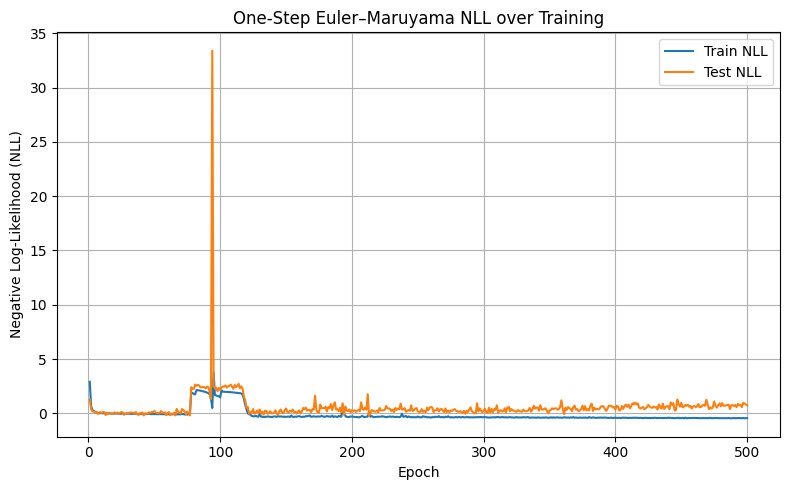

In [29]:
from torch import nn
# Extract the underlying price and timestamp for both train and test
S_train = train_df[['timestamp', 'index_price']].drop_duplicates('timestamp').set_index('timestamp').sort_index()
S_test = test_df[['timestamp', 'index_price']].drop_duplicates('timestamp').set_index('timestamp').sort_index()

S_train = S_train.reindex(train_proj.index).ffill().bfill()
S_test  = S_test.reindex(test_proj.index).ffill().bfill()

# 1c) optionally model log‐spot for numerical stability
logS_train = np.log(S_train['index_price'].values)
logS_test  = np.log(S_test['index_price'].values)

spot_train = torch.from_numpy(logS_train).unsqueeze(1).float().to(device)   # [T,1]
spot_test  = torch.from_numpy(logS_test ).unsqueeze(1).float().to(device)


Y_train = torch.cat([spot_train, torch.from_numpy(ξ_train)], dim=1)  # (T_train, d+1)
Y_test  = torch.cat([spot_test,  torch.from_numpy(ξ_test)],  dim=1)  # (T_test,  d+1)

# Load dt tensor
dt_test = torch.load("dt_test.pt")
dt_train = torch.load("dt_train.pt")

# align dt
dt_train = dt_train.to(device)
dt_test = dt_test.to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)

Axi_t  = torch.from_numpy(Axi).float().to(device)    # (m, d)
bxi_t  = torch.from_numpy(bxi).float().to(device)    # (m,)
zeta_t = torch.from_numpy(Zeta).float().to(device)   # (m, d)

Y_train = Y_train.float()
Y_test  = Y_test.float()
dt_train_pairs = dt_train_pairs.float()
dt_test_pairs  = dt_test_pairs.float()

# 3) Instantiate your constrained SDE:
#    dim = number of factors = Y_train.shape[1] - 1
dim = Y_train.shape[1] - 1
model = ConstrainedSDE(
    dim  = dim,
    Axi  = Axi_t,
    bxi  = bxi_t,
    zeta = zeta_t,
    lam  = 10.0,
    eps  = 1e-3
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4) Training loop (one‐step Euler–Maruyama NLL):
n_epochs   = 500
batch_size = 60
n_train    = Y_train.size(0)

train_losses = []
test_losses  = []

for epoch in range(1, n_epochs+1):
    model.train()
    perm = torch.randperm(n_train - 1, device=device)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = Y_train[idx]         # (B, d+1)
        y1 = Y_train[idx + 1]     # (B, d+1)
        dt = dt_train_pairs[idx]  # (B, 1)

        μ   = model.f(0, y0)      # (B, d+1)
        σ   = model.g(0, y0)      # (B, d+1)
        dy  = y1 - y0             # (B, d+1)
        var = σ**2 * dt + 1e-6    # (B, d+1)

        nll  = 0.5 * ((dy - μ*dt)**2 / var + torch.log(2*math.pi*var))
        loss = nll.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_losses.append(epoch_loss / (n_train - 1))

    # 5) Evaluate on test
    model.eval()
    with torch.no_grad():
        y0 = Y_test[:-1]
        y1 = Y_test[1:]
        dt = dt_test_pairs

        μ_t   = model.f(0, y0)
        σ_t   = model.g(0, y0)
        dy_t  = y1 - y0
        var_t = σ_t**2 * dt + 1e-6

        nll_t     = 0.5 * ((dy_t - μ_t*dt)**2 / var_t + torch.log(2*math.pi*var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch}/{n_epochs}  Train NLL: {train_losses[-1]:.4e}  Test NLL: {test_losses[-1]:.4e}")

    import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are Python lists of length n_epochs
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train NLL")
plt.plot(epochs, test_losses,  label="Test NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood (NLL)")
plt.title("One-Step Euler–Maruyama NLL over Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# y0 = Y_test[:-1]; dy = (Y_test[1:,0] - Y_test[:-1,0])
dt = dt_test_pairs.squeeze()
phi_mu = model.f(0, y0)[:,0].cpu().numpy()
phi_sig= model.g(0, y0)[:,0].cpu().numpy()
emp_sig= (dy.abs()/dt.sqrt()).cpu().numpy()

plt.figure()
plt.subplot(1,2,1)
plt.scatter(phi_mu, np.zeros_like(phi_mu), s=2); plt.title("Drift φ_S^μ")
plt.subplot(1,2,2)
plt.scatter(emp_sig, phi_sig, s=2); plt.plot([0,emp_sig.max()],[0,emp_sig.max()],"k--")
plt.title("Diffusion φ_S^σ")


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.